In [0]:
q# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.colors
import imageio
import seaborn as sns

import os
from sklearn.metrics import log_loss,mean_squared_error,accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
def displayImage(file_path):
    image = Image.open(file_path)
    image = image.convert('L')
    plt.imshow(image)
    plt.show()

In [0]:
def read_single_image(folder_path,image_no):
    files = os.listdir(folder_path)
    file_path = os.path.join(folder_path,files[image_no])
    displayImage(file_path)

This clearly shows that I need to bring all the images to the same shape because all images have different shape.

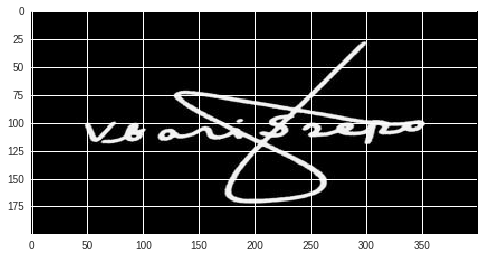

In [0]:
read_single_image("./drive/My Drive/signature data/folder7",0)
# display_numpy_array("./drive/My Drive/Untitled folder/signature/001",0)

In [0]:
W1 = np.array(pd.read_csv('W1.csv',header = None))
W2 = np.array(pd.read_csv('W2.csv',header = None))
B1 = np.array(pd.read_csv('B1.csv',header = None))
B2 = np.array(pd.read_csv('B2.csv',header = None))

In [0]:
print(W1.shape)

(80000, 10)


In [0]:
# X_train[0].shape

In [0]:
class VectorizedInput_ff_nn:
    def __init__(self,W1,W2):
        self.W1 = W1.copy()  # this is deep copy, we are not just providing the reference
        self.W2 = W2.copy()
        self.B1 = B1.copy()
        self.B2 = B2.copy()
    
    def sigmoid(self,X):
        return 1.0/(1.0 + np.exp(-X))
    
    def softmax(self,X):
        exps = np.exp(X)
        return exps / np.sum(exps,axis = 1).reshape(-1,1)
    
    def forward_pass(self,X):
        self.A1 = np.matmul(X,self.W1) + self.B1 # (1,5000) * (5000,3) -> (1,3) + (1,3) -> (1,3)
#         print('A1')
#         print(self.A1[2])
        self.H1 = self.sigmoid(self.A1) # (1,2)
#         print('H1')
#         print(self.H1[2])
        self.A2 = np.matmul(self.H1,self.W2) + self.B2  # (1,2) * (2,4) -> (1,4) + (1,4) -> (1,4)
#         print('A2')
#         print(self.A2[0])
        self.H2 = self.softmax(self.A2) # (1,4)
#         print('H2')
#         print(self.H2[0])
        return self.H2
    
    def grad_sigmoid(self,X):
        return X*(1-X)
    
    def grad(self,X,Y):
        self.forward_pass(X)
#         x = x.reshape(1,-1)   # (1,2)
#         y = y.reshape(1,-1)   # (1,4)

        m = X.shape[0]
        
        self.dA2 = self.H2 - Y
#         print('dA2')
#         print(self.dA2[0])
        
        self.dW2 = np.matmul(self.H1.T,self.dA2)
        
#         print('dW2')
#         print(self.dW2[0])
        
        self.dB2 = np.sum(self.dA2,axis = 0).reshape(1,-1)
#         print('dB2')
#         print(self.dB2[0])
        
        self.dH1 = np.matmul(self.dA2,self.W2.T)
        
#         print('dH1')
#         print(self.dH1[0])
        
        self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1))
        
#         print('dA1')
#         print(self.dA1[0])
        
        self.dW1 = np.matmul(X.T,self.dA1)
        self.dB1 = np.sum(self.dA1,axis = 0).reshape(1,-1)
        
#         print('dB1')
#         print(self.dB1[0])
        
    def fit(self, X, Y, epochs = 1,learning_rate = 1, display_loss = False, display_weight = False):
        if display_loss:
            loss = {}
            
        for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
#             dW1 = np.zeros((2,2))
#             dW2 = np.zeros((2,4))
#             dB1 = np.zeros((1,2))
#             dB2 = np.zeros((1,4))
            
#             for x,y in zip(X,Y):
            self.grad(X,Y)
#                 dW1 += self.dW1
#                 dW2 += self.dW2
#                 dB1 += self.dB1
#                 dB2 += self.dB2
                
            m = X.shape[0]
            self.W2 -= learning_rate * (self.dW2/m)
            self.B2 -= learning_rate * (self.dB2/m)
            self.W1 -= learning_rate * (self.dW1/m)
            self.B1 -= learning_rate * (self.dB1/m)
            
            if display_loss:
                Y_pred = self.predict(X)
                loss[i] = log_loss(np.argmax(Y, axis = 1),Y_pred)
#             print(loss[i])
            
            if display_weight:
#                 print(self.W2)
#                 print(' ')
                weight_matrices.append(self.W2)
                grad_weights.append(self.dW2)
                
        if display_loss:
            plt.plot(loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    
    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

In [0]:
def read_all(folder_path):
#     print("reading")
    images = {}
    files = os.listdir(folder_path)
#     for i, file_name in tqdm_notebook(enumerate(files),total = len(files)):
    for file_name in files:
        file_path = os.path.join(folder_path,file_name)
        image_index = file_name[:-4]
        image = Image.open(file_path)
#         image = image_resize(file_path)
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images
        

# Training with initialization

In [0]:
W2

array([[ 0.50640483, -0.5048493 ],
       [ 0.53526968, -0.53555618],
       [ 0.4770668 , -0.47789792],
       [ 0.49515741, -0.49435793],
       [ 0.57360025, -0.57245966],
       [ 0.47797337, -0.47783106],
       [ 0.46821495, -0.46674301],
       [ 0.36862992, -0.36687815],
       [ 0.4879943 , -0.48915292],
       [ 0.53908213, -0.53950201]])

In [0]:
images_train = {}
print("reading")
# for i, ele in tqdm_notebook(enumerate(folder_names),total = len(folder_names)):
for i in tqdm_notebook(range(7,10)):
#     print('reading')
    images_train.update(read_all('./drive/My Drive/signature data/folder'+'{}'.format(i)))
    
# ---------------------------------------------------------------------------------------------------------
    
X_train = []
Y_train = []
for key,value in images_train.items():
    X_train.append(value)
    if key[:2] == 'cf':
        Y_train.append(0)
    else:
        Y_train.append(1)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# ---------------------------------------------------------------------------------------------------------

# images_train.clear()

# ---------------------------------------------------------------------------------------------------------



reading


In [0]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
# y_OH_val = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
# print(y_OH_train.shape, y_OH_val.shape)

In [0]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [0]:

# W1 = np.random.rand(5000,3) # (2,2)
# W2 = np.random.rand(3,2) # (2,4)

# W1 = np.random.uniform(low=-0.001, high=0.001, size=(80000,10) )
# W2 = np.random.uniform(low=-0.001, high=0.001, size=(10,2) )
# B1 = np.zeros((1,10))
# B2 = np.zeros((1,2))

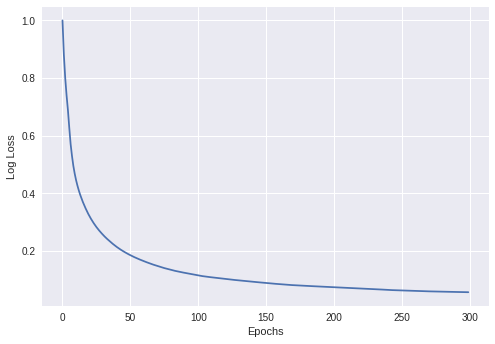

In [0]:
weight_matrices = []
grad_weights = []
obj2 = VectorizedInput_ff_nn(W1,W2)
obj2.fit(X_train,y_OH_train,epochs=300,learning_rate=0.1,display_loss=True,display_weight = True)

Training of first 3 folders after initialization ends here.

# without initialization

In [0]:
images_train = {}
print("reading")
# for i, ele in tqdm_notebook(enumerate(folder_names),total = len(folder_names)):
for i in tqdm_notebook(range(10,13)):
#     print('reading')
    images_train.update(read_all('./drive/My Drive/signature data/folder'+'{}'.format(i)))
    
# ---------------------------------------------------------------------------------------------------------
    
X_train = []
Y_train = []
for key,value in images_train.items():
    X_train.append(value)
    if key[:2] == 'cf':
        Y_train.append(0)
    else:
        Y_train.append(1)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# ---------------------------------------------------------------------------------------------------------

images_train.clear()

# ---------------------------------------------------------------------------------------------------------



reading


In [0]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
# y_OH_val = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
# print(y_OH_train.shape, y_OH_val.shape)

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

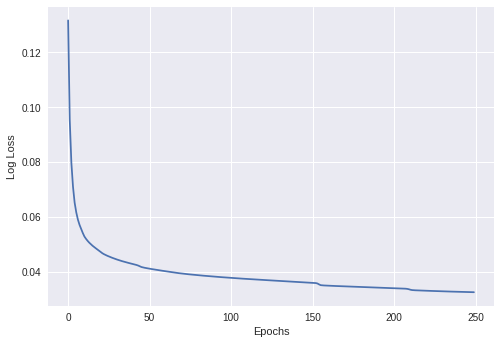

In [0]:
obj2.fit(X_train,y_OH_train,epochs=250,learning_rate=0.1,display_loss=True,display_weight = True)

# testing part

In [0]:
images_train = {}
print("reading")
# for i, ele in tqdm_notebook(enumerate(folder_names),total = len(folder_names)):
for i in tqdm_notebook(range(1,13)):
#     print('reading')
    images_train.update(read_all('./drive/My Drive/signature data/Tfolder'+'{}'.format(i)))

reading


In [0]:
X_test = []
Y_test = []
for key,value in images_train.items():
    X_test.append(value)
    if key[:2] == 'cf':
        Y_test.append(0)
    else:
        Y_test.append(1)
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [0]:
X_test = scaler.transform(X_test)

In [0]:
# enc = OneHotEncoder()
# y_OH_val = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()

In [0]:
Y_pred_train = obj2.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_test = obj2.predict(X_test)
Y_pred_test = np.argmax(Y_pred_test,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_test = accuracy_score(Y_pred_test, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_test, 2))

Training accuracy 0.99
Validation accuracy 0.56


Here, **main code** ends

# Rough code

In [0]:
new_W1 = obj2.W1
new_W2 = obj2.W2
new_B1 = obj2.B1
new_B2 = obj2.B2

In [0]:
new_W2

array([[ 0.78561015, -0.78405462],
       [ 0.60192973, -0.60221624],
       [ 0.8265984 , -0.82742952],
       [ 1.05764212, -1.05684265],
       [ 1.06700433, -1.06586374],
       [ 0.49882064, -0.49867833],
       [ 0.97656806, -0.97509611],
       [ 0.81289098, -0.8111392 ],
       [ 0.86231064, -0.86346926],
       [ 0.7216538 , -0.72207368]])

In [0]:
new_W2

array([[ 0.78561015, -0.78405462],
       [ 0.60192973, -0.60221624],
       [ 0.8265984 , -0.82742952],
       [ 1.05764212, -1.05684265],
       [ 1.06700433, -1.06586374],
       [ 0.49882064, -0.49867833],
       [ 0.97656806, -0.97509611],
       [ 0.81289098, -0.8111392 ],
       [ 0.86231064, -0.86346926],
       [ 0.7216538 , -0.72207368]])

In [0]:
np.savetxt("W1.csv", new_W1, delimiter=",")
np.savetxt("W2.csv", new_W2, delimiter=",")
np.savetxt("B1.csv", new_B1, delimiter=",")
np.savetxt("B2.csv", new_B2, delimiter=",")

In [0]:
temp = np.array(pd.read_csv('temp.csv',header = None))

In [0]:
temp.shape

(80000, 10)

Now the only option for me is to check the weights i.e. how they are transitioning

In [0]:
# def plot_heat_map(epoch):
#     fig = plt.figure(figsize = (2,2))
#     sns.heatmap(weight_matrices[epoch],annot = True,cmap = my_cmap,vmin = -5,vmax = 5)
#     plt.title("Epoch"+str(epoch))
    
#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
#     return image

In [0]:
# imageio.mimsave('./weights_viz.gif', [plot_heat_map(i) for i in range(0,len(weight_matrices),len(weight_matrices)//10)], fps=1)

In [0]:
images_train = {}
print("reading")
# for i, ele in tqdm_notebook(enumerate(folder_names),total = len(folder_names)):
for i in tqdm_notebook(range(4,7)):
#     print('reading')
    images_train.update(read_all('./drive/My Drive/signature data/folder'+'{}'.format(i)))

reading


In [0]:
X_train = []
Y_train = []
for key,value in images_train.items():
    X_train.append(value)
    if key[:2] == 'cf':
        Y_train.append(0)
    else:
        Y_train.append(1)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [0]:
images_train.clear()

In [0]:
W1 = new_W1
W2 = new_W2
B1 = new_B1
B2 = new_B2

In [0]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
# y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
# print(y_OH_train.shape, y_OH_val.shape)

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

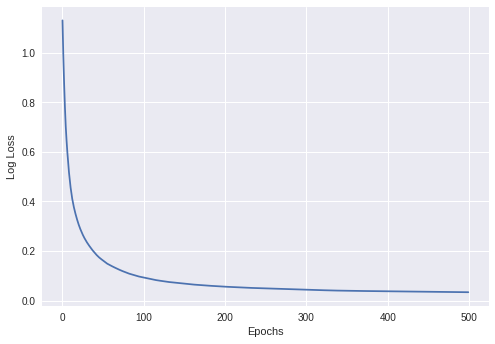

In [0]:
weight_matrices = []
grad_weights = []
obj2 = VectorizedInput_ff_nn(W1,W2)
obj2.fit(X_train,y_OH_train,epochs=500,learning_rate=0.1,display_loss=True,display_weight = True)

In [0]:
Y_pred_train = obj2.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_test = obj2.predict(X_test)
Y_pred_test = np.argmax(Y_pred_test,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_test = accuracy_score(Y_pred_test, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_test, 2))

Training accuracy 0.99
Validation accuracy 0.44
